# Deep Learning based classification

In the previous notebooks `4-CSP-based-classification` and `5-CSP-params-new-subject`, we used CSP as a way to engineer feautures from raw EEG data and used common ML classifiers to use those features for classification.
This had very varying results.
As said by Kostas et al ([2021](https://doi.org/10.3389/fnhum.2021.653659)): 
>Deep Neural Network (DNN) models used for classifying EEG data thus need to both develop useful features from EEG signals and subsequently classify those features.
>This frames both the promise and the challenge of using DNNs for supervised EEG classification. 
>On the one hand, it promises to almost entirely circumvent the need for feature engineering, but on the other hand, both feature discovery and classification need to be learned from a limited supply of (relevant) high-dimensional data.


In this notebook we will explore 3 common Deep Learnging (DL) algorithms for EEG classifications: [EEGNet V2](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta), [DeepConvNet](https://doi.org/10.1002/hbm.23730) and [ShallowConvNet](https://doi.org/10.1002/hbm.23730).
It is noted that these models are designed with larger windows in mind (often 2s and more).


## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- EEGNet
  - Fixed window classification: Single trial | EEGNet | three class MI task | 100Hz input signal
  - Fixed window classification: Multi trial training with unseen trial testing | EEGNet | three class MI task | 100Hz input signal
- ShallowConvNet
  - Fixed window classification: Single trial | ShallowConvNet | three class MI task | 100Hz input signal
  - Fixed window classification: Multi trial training with unseen trial testing | ShallowConvNet | three class MI task | 100Hz input signal
- DeepConvNet
  - Fixed window classification: Single trial | DeepConvNet | three class MI task | 100Hz input signal
  - Fixed window classification: Multi trial training with unseen trial testing | DeepConvNet | three class MI task | 100Hz input signal

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules and show if the versions match those that are recommended.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# Load EEGModels
import EEGModels
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

import pyriemann as prm; print(f"PyRieMann version (0.2.7 recommended): {prm.__version__}")

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
PyRieMann version (0.2.7 recommended): 0.2.7
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. FIF files from this same dataset are also made available in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). A check on the availability of these two datasets is performed below.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Checking TensorFlow GPU support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


print("\n\nNum CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices('CPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


<hr><hr>

## Loading in data

In this step, we load the data.
The loaded data is that of a specific subject and thus can exist of multiple MNE RAW objects.
This list of objects is provided as well as a singular one, namely the first of the list.

It is important to note that the data stored by MNE is in volts meaning the values are very small.
This is not ideal for DL methods, and thus it is recommended to multiply the data before feeding it to the DL pipeline.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [5]:
####################################################
# LOADING RAW MNE DATA AND EPOCS
####################################################

def load_mne_raws(subject: str):
    return [raw.load_data() for raw in CLA_dataset.get_raw_mne_data_for_subject(subject)]

def load_mne_raw(subject: str, index: int):
    return CLA_dataset.get_raw_mne_data_for_subject(subject)[index].load_data()


<hr> <hr>

## Global variables

In [6]:
####################################################
# Global vars
####################################################

def tensorboard_callback(log_name: str):
    return tf.keras.callbacks.TensorBoard('./logs/' + log_name,
                                          update_freq="batch",
                                          profile_batch=0)

def lowest_loss_model_save_callback(filepath: str):
    filepath = filepath + "_lowest_loss_model.hdf5"
    return ModelCheckpoint(filepath=filepath,
                           monitor= 'val_loss',
                           verbose=1, 
                           save_best_only=True,
                           mode= 'min')
    
def load_lowest_loss_model(filepath: str, custom_objects = {}):
    filepath = filepath + "_lowest_loss_model.hdf5"
    return keras.models.load_model(filepath, custom_objects=custom_objects)

def highest_accuracy_model_save_callback(filepath: str):
    filepath = filepath + "_highest_acc_model.hdf5"
    return ModelCheckpoint(filepath=filepath,
                           monitor= 'val_accuracy',
                           verbose=1, 
                           save_best_only=True,
                           mode= 'max')
    
def load_highest_accuracy_model(filepath: str, custom_objects = {}):
    filepath = filepath + "_highest_acc_model.hdf5"
    return keras.models.load_model(filepath, custom_objects=custom_objects)
    

<hr> <hr>

## Tensorboard

To launch the tensorboard use the following command in the `experimental-notebooks` folder:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

<hr><hr>

## EEGNet

EEGNet is a compact convolutional neural network for EEG-based brain–computer interfaces by Lawhern et al ([2018](https://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta)). There were two proposed version, the latter of which is the referenced published version. Since the latter performs fat better and is the most commonly known EEGNet, this V2 is used here. The EEGModels library provided by the Army Research Laboratory on [GitHub](https://github.com/vlawhern/arl-eegmodels) is used for easy use of this model.

### Fixed window classification: Single trial | EEGNet | three class MI task | 100Hz input signal

The model recommends using 128 samples.
If you remember from the previous notebooks, the data was sampled at 200Hz, which means there are 200 samples per second.
In the previous notebook we processed data of 0.5 seconds, thus 100 samples.
To get initial results, we will use the model on this 100 samples data.

The scores are given for the best CSP approach as well as for the trained DL approach.
Scores for the DL approach are a combination of the best model based on validation loss / validation accuracy.
TensorBoard was used to monitor the behaviour of the model over time, to ensure no overfitting tendencies occur and that enough epochs have happened to learn optimally.

**The result on subject `C` are:**


| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** |
|----------------|------------------------------------|---------------------------------|
| 0              | 0.896                              | 0.944 / 0.934                   |
| 1              | 0.847                              | 0.931 / 0.913                   |
| 2              | 0.719                              | 0.892 / 0.878                   |

**The result on subject `B` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** |
|----------------|------------------------------------|---------------------------------|
| 0              | 0.465                              | 0.569 / 0.587                   |
| 1              | 0.560                              | 0.701 / 0.684                   |
| 2              | 0.653                              | 0.816 / 0.792                   |


**The result on subject `E` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** |
|----------------|------------------------------------|---------------------------------|
| 0              | 0.701                              | 0.792 / 0.785                   |
| 1              | 0.580                              | 0.795 / 0.799                   |
| 2              | 0.805                              | 0.864 / 0.864                   |

It is important to note the training behaviour of the models has greatly improved when multiplying the data by a million.
See the comparison of the accuracy score on the validation set for subject `0` with the file at index 0 for example.
All settings of the model are equal but one has multiplied the data by a million before training.
The better behaving model is that with the data multiplied.

![Comparison of models using multiplied data vs non multiplied data](figures/6-dl/eegnet_multiplied_data.PNG)

In [7]:
####################################################
# PREPPING THE DATA
####################################################

# Specify raw to use
mne_raw = load_mne_raw(subject= "C", index=0)

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs, we don't need filtering since this is what we want to learn!
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Labels: should be one hot encoded!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

# Go to 2D representation
labels = labels.reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(labels).toarray()
print(f"One Hot Encoded labels: {ohe_labels[:10]}")

# Show ohe labels
np.shape(ohe_labels)
ohe_labels[:10]

# Validate OHE
print(f"Labels match before and after the One Hot Encoding: {np.array_equal(ohe.inverse_transform(ohe_labels), labels)}")

# Get effective data (half a second)
mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_data = mne_fixed_window_epochs_data * 1000000

# Delete unused variables
del mne_fixed_window_epochs
print(f"Shape of data (epochs, channels, samples): {np.shape(mne_fixed_window_epochs_data)}")

# Remove unused variables
del labels

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Using data from preloaded Raw for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]
One Hot Encoded labels: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Labels match before and after the One Hot Encoding: True
Shape of data (epochs, channels, samples): (960, 21, 100)


In [8]:
####################################################
# CREATE EEGNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_eegnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_eegnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 21, 100, 8)        400       
                                                                 
 batch_normalization (BatchN  (None, 21, 100, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 100, 16)       336       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                             

Results for lowest loss model
Trained EEGNet on single session using train/test split and got accuracy of: 0.9444444444444444


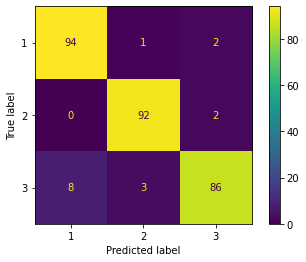



Results for highest accuracy model
Trained EEGNet on single session using train/test split and got accuracy of: 0.9340277777777778


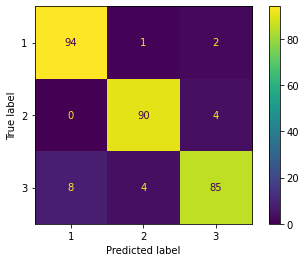

In [9]:
####################################################
# SINGLE TRIAL EEGNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "EEGNet_singlesession_C0_100hz"
best_model_filename = f"./saved_variables/6/EEGNet/{tensorboard_name}"

# Get train/test split of data from one session
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, ohe_labels, 
                                                    test_size = 0.3,
                                                    shuffle= True,
                                                    stratify= ohe_labels,                                                    
                                                    random_state=98)


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_eegnet_model.fit(
            x= X_train,
            y= y_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            #callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02nr")], # To be used for TF Board
            callbacks= [tensorboard_callback(tensorboard_name),
                        lowest_loss_model_save_callback(best_model_filename),
                        highest_accuracy_model_save_callback(best_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Convert labels back to original
y_test = ohe.inverse_transform(y_test)

# Get results for best validation loss model
print("Results for lowest loss model")
keras_eegnet_model = load_lowest_loss_model(best_model_filename)

y_pred = keras_eegnet_model.predict(X_test)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained EEGNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model")
keras_eegnet_model = load_highest_accuracy_model(best_model_filename)

y_pred = keras_eegnet_model.predict(X_test)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained EEGNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del X_train
del X_test
del y_train
del y_test
del accuracy
del y_pred
del retrain_model
del tensorboard_name
del best_model_filename

In [10]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_eegnet_model
del mne_fixed_window_epochs_data
del ohe
del ohe_labels
del mne_raw

<hr>

### Fixed window classification: Multi trial training with unseen trial testing | EEGNet | three class MI task | 100Hz input signal

Having the best performance on single trials, it is expected EEGNet will perform very well on the multi trial training and single trial testing experiments as well.
We test this here.
The scores given are best loss/ best accuracy.

**Remember the results for subject `C`**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|
| 0              | 1 + 2           | 0.782                        | 0.916 / 0.920             |
| 1              | 0 + 2           | 0.635                        | 0.852 / 0.860             |
| 2              | 1 + 2           | 0.347                        | 0.607 / 0.594             |
| 0              | 1               | 0.667                        | 0.891 / 0.860             |
| 1              | 0               | 0.662                        | 0.794 / 0.783             |

For test index 2 trained on index 0 and 1, EEGNet is the first to somewhat accurately predict the third neutral class as well.

**For subject `B` these results are**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|
| 0              | 1 + 2           | 0.409                        | 0.498 / 0.489             |
| 1              | 0 + 2           | 0.497                        | 0.640 / 0.654             |
| 2              | 1 + 2           | 0.502                        | 0.677 / 0.660             |

**For subject `E` the results are**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|
| 0              | 1 + 2           | 0.398                        | 0.714 / 0.713             |
| 1              | 0 + 2           | 0.371                        | 0.667 / 0.646             |
| 2              | 1 + 2           | 0.475                        | 0.734 / 0.688             |

Again, we see that the DL approach using EEGNet far outperforms the CSP approach.

In [11]:
####################################################
# PREPPING THE DATA
####################################################

# Get data and choose test trial
mne_raws = load_mne_raws(subject= "C")
test_trial = mne_raws[0]

# Init variables
epochs = []
labels_train = []

for single_mne_raw in mne_raws:
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print("Loaded train epochs and extracted labels")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nGot the test epochs")
print(f"Total amount of train labels: {len(labels_test)}")

# Go to 2D representation
labels_train = np.array(labels_train).reshape(-1, 1)
labels_test = np.array(labels_test).reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels_train = ohe.fit_transform(labels_train).toarray()
ohe_labels_test = ohe.transform(labels_test).toarray()


# Show ohe labels
print(f"OHE test and train labels, train labels:\n{ohe_labels_train[:10]}")

# Validate OHE
print(f"Train labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_train), labels_train)}")
print(f"Test labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_test), labels_test)}")

# Get training data
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train_data * 1000000
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test_data * 1000000

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw
del mne_raws
del mne_fixed_window_epochs_train
del mne_fixed_window_epochs_test
del labels_train
del labels_test

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Loaded test epochs and extracted labels
Loaded train epochs and extracted labels
Loaded train epochs and extracted labels


Concatenated the train epochs
Total amount of train labels: 1919


C:\Users\Lennert\AppData\Local\Temp\ipykernel_16324\2395505687.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
C:\Users\Lennert\AppData\Local\Temp\ipykernel_16324\2395505687.py:34: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)




Got the test epochs
Total amount of train labels: 960
OHE test and train labels, train labels:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Train labels OHE match regular labels: True
Test labels OHE match regular labels: True


In [12]:
####################################################
# CREATE EEGNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_eegnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_eegnet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_3 (Batc  (None, 21, 100, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                           

Results for lowest loss model
Trained EEGNet on single session using train/test split and got accuracy of: 0.915625


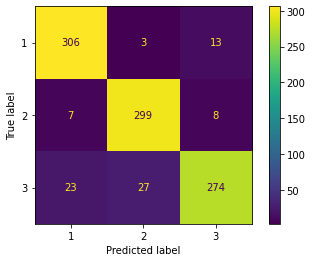



Results for highest accuracy model
Trained EEGNet on single session using train/test split and got accuracy of: 0.9197916666666667


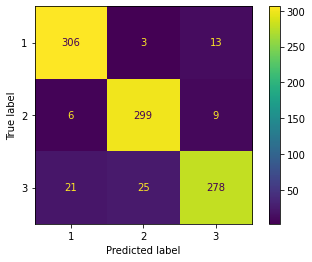

In [13]:
####################################################
# MULTI TRIAL EEGNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "EEGNet_multisession_C0_100hz"
best_model_filename = f"./saved_variables/6/EEGNet/{tensorboard_name}"


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_eegnet_model.fit(
            x= mne_fixed_window_epochs_train_data,
            y= ohe_labels_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            #callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02nr")], # To be used for TF Board
            callbacks= [tensorboard_callback(tensorboard_name),
                        lowest_loss_model_save_callback(best_model_filename),
                        highest_accuracy_model_save_callback(best_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Convert labels back to original
y_test = ohe.inverse_transform(ohe_labels_test)

# Get results for best validation loss model
print("Results for lowest loss model")
keras_eegnet_model = load_lowest_loss_model(best_model_filename)

y_pred = keras_eegnet_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained EEGNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model")
keras_eegnet_model = load_highest_accuracy_model(best_model_filename)

y_pred = keras_eegnet_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained EEGNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del accuracy
del best_model_filename
del retrain_model
del tensorboard_name
del y_pred
del y_test

In [14]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_eegnet_model
del mne_fixed_window_epochs_test_data
del mne_fixed_window_epochs_train_data
del ohe
del ohe_labels_test
del ohe_labels_train

<hr><hr>

## ShallowConvNet

The ShallowConvNet and DeepConvNet are implementations of the models described by Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730)).
They are shallow and deep convolutional neural networks both presented in the same paper.
CNN's have been proven to be very good at image classification tasks, thus EEG-as-image approaches have been used in the past where an image representation of the EEG signal is processed by popular CNN architectures.
The approach by Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730) works with raw EEG however, which seems like a better approach.
This makes the pipeline more efficient but also means that the architectures from image processing can't be blindly adopted.
Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730)) have shown that their method outperforms Filter Bank Common Spatial Patterns (FBCSP), so it should outperform our naive CSP experiment results from the previous notebooks.

We will first explore the ShallowConvNet method.
The original implementation of the model works on 250Hz data.
The defaults provided by the EEGModels library are adopted for 128Hz, we will further adapt it to 100Hz here.
Contrary to the EEGNet implementation of EEGModels, the implementation of ShallowConvNet and DeepConvNet are not verified by the original authors, Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730)).
However, the found results are in line with the paper, thus the implementation is believed to be correct.

### Fixed window classification: Single trial | ShallowConvNet | three class MI task | 100Hz input signal

As discussed, the original implementation of the model works on 250Hz data.
The defaults provided by the EEGModels library are adopted for 128Hz, we will further adapt it to 100Hz here.
If you remember from the previous notebooks, the data was sampled at 200Hz, which means there are 200 samples per second.
In the previous notebook we processed data of 0.5 seconds, thus 100 samples.
To get initial results, we will use the model on this 100 samples data.

This more shallow architecture is inspired by FBCSP and specifically tailored to decode band power features as discussed by Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730).
Because of this, it is expected to be far better then CSP and ideally it would rival EEGNet on single trial performance.
However, as it is still based on CSP, albeit a FBCSP, it is expected that problems could arise with inter-session and inter-patient experiments.


The scores are given for the best CSP approach as well as for the trained DL approach.
Scores for the DL approach are a combination of the best model based on validation loss / validation accuracy.
TensorBoard was used to monitor the behaviour of the model over time, to ensure no overfitting tendencies occur and that enough epochs have happened to learn optimally.

**The result on subject `C` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** |
|----------------|------------------------------|---------------------------|-----------------------------------|
| 0              | 0.896                        | 0.944 / 0.934             | 0.951 / 0.955                     |
| 1              | 0.847                        | 0.931 / 0.913             | 0.937 / 0.937                     |
| 2              | 0.719                        | 0.892 / 0.878             | 0.868 / 0.871                     |

**The result on subject `B` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** |
|----------------|------------------------------|---------------------------|-----------------------------------|
| 0              | 0.465                        | 0.569 / 0.587             | 0.496 / 0.542                     |
| 1              | 0.560                        | 0.701 / 0.684             | 0.649 / 0.601                     |
| 2              | 0.653                        | 0.816 / 0.792             | 0.694 / 0.712                     |


**The result on subject `E` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** |
|----------------|------------------------------|---------------------------|-----------------------------------|
| 0              | 0.701                        | 0.792 / 0.785             | 0.802 / 0.806                     |
| 1              | 0.580                        | 0.795 / 0.799             | 0.826 / 0.823                     |
| 2              | 0.805                        | 0.864 / 0.864             | 0.916 / 0.923                     |

The training of this network is considerably faster as it takes less epochs to converge.
The modification to let us set extra parameters for this model has shown to be improving of the model's performance on all aspects.
However, with a near 1 accuracy, there are signs of overfitting.
Being a somewhat CSP based approach, it is expected that well MI capable patient performance would be high whilst hard patients such as subject `B` would be low.

In [15]:
####################################################
# PREPPING THE DATA
####################################################

# Specify raw to use
mne_raw = load_mne_raw(subject= "C", index= 0)

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs, we don't need filtering since this is what we want to learn!
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Labels: should be one hot encoded!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

# Go to 2D representation
labels = labels.reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(labels).toarray()
print(f"One Hot Encoded labels: {ohe_labels[:10]}")

# Show ohe labels
np.shape(ohe_labels)
ohe_labels[:10]

# Validate OHE
print(f"Labels match before and after the One Hot Encoding: {np.array_equal(ohe.inverse_transform(ohe_labels), labels)}")

# Get effective data (half a second)
mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_data = mne_fixed_window_epochs_data * 1000000

# Delete unused variables
del mne_fixed_window_epochs
print(f"Shape of data (epochs, channels, samples): {np.shape(mne_fixed_window_epochs_data)}")

# Remove unused variables
del labels

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Using data from preloaded Raw for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]
One Hot Encoded labels: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Labels match before and after the One Hot Encoding: True
Shape of data (epochs, channels, samples): (960, 21, 100)


#### Note on the ShallowConvNet model

The ShallowConvNet implementation used was provided by the Army Research Laboratory on [GitHub](https://github.com/vlawhern/arl-eegmodels).
However, they hard coded some model parameters we found important to modify and thus we edited their model definition slightly to allow for setting extra parameters dynamically.

In [16]:
####################################################
# CREATE SHALLOWCONVNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_shallowcn_model = ShallowConvNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128, paper: 250)
    dropoutRate = 0.8, # dropout fraction. (default: 0.5)
    conv_filters = 10, # Conv2D kernel size (default: 13, paper: 25)
    strides = 6, # Stride size for average pooling layer (default: 7, paper: 15)
    pool_size = 30 # Pool size for average pooling layer (default: 35, paper: 75)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_shallowcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_shallowcn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 91, 40)        440       
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 91, 40)         33600     
                                                                 
 batch_normalization_6 (Batc  (None, 1, 91, 40)        160       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 1, 91, 40)         0         
                                                                 
 average_pooling2d_4 (Averag  (None, 1, 11, 40)        0         
 ePooling2D)                                               

Results for lowest loss model
Trained ShallowConvNet on single session using train/test split and got accuracy of: 0.9513888888888888


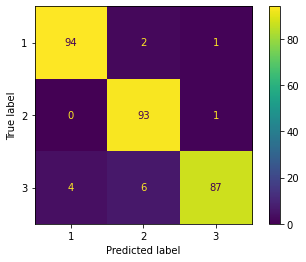



Results for highest accuracy model
Trained ShallowConvNet on single session using train/test split and got accuracy of: 0.9548611111111112


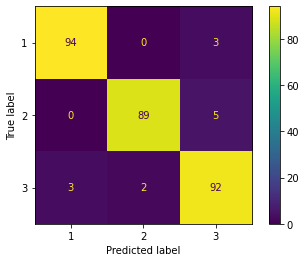

In [17]:
####################################################
# SINGLE TRIAL SHALLOWCONVNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "ShallowCN_singlesession_C0_100hz_08drop"
best_model_filename = f"./saved_variables/6/ShallowConvNet/{tensorboard_name}"

# Get train/test split of data from one session
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, ohe_labels, 
                                                    test_size = 0.3,
                                                    shuffle= True,
                                                    stratify= ohe_labels,                                                    
                                                    random_state=98)


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_shallowcn_model.fit(
            x= X_train,
            y= y_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            #callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02nr")], # To be used for TF Board
            callbacks= [tensorboard_callback(tensorboard_name),
                        lowest_loss_model_save_callback(best_model_filename),
                        highest_accuracy_model_save_callback(best_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Convert labels back to original
y_test = ohe.inverse_transform(y_test)

# Get results for best validation loss model
print("Results for lowest loss model")
keras_shallowcn_model = load_lowest_loss_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_shallowcn_model.predict(X_test)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained ShallowConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model")
keras_shallowcn_model = load_highest_accuracy_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_shallowcn_model.predict(X_test)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained ShallowConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del X_train
del X_test
del y_train
del y_test
del accuracy
del y_pred
del retrain_model
del tensorboard_name
del best_model_filename

In [18]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_shallowcn_model
del mne_fixed_window_epochs_data
del ohe
del ohe_labels
del mne_raw

<hr>

### Fixed window classification: Multi trial training with unseen trial testing | ShallowConvNet | three class MI task | 100Hz input signal

Having equally good if not better performance then EEGNet, it is studied if the inter-session performance is also as good or better.
The scores given are best loss/ best accuracy.

**Remember the results for subject `C`**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|-----------------------------------|
| 0              | 1 + 2           | 0.782                        | 0.916 / 0.920             | 0.903 / 0.910                     |
| 1              | 0 + 2           | 0.635                        | 0.852 / 0.860             | 0.782 / 0.787                     |
| 2              | 1 + 2           | 0.347                        | 0.607 / 0.594             | 0.509 / 0.489                     |
| 0              | 1               | 0.667                        | 0.891 / 0.860             | 0.872 / 0.872                     |
| 1              | 0               | 0.662                        | 0.794 / 0.783             | 0.713 / 0.731                     |

**For subject `B` these results are**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|-----------------------------------|
| 0              | 1 + 2           | 0.409                        | 0.498 / 0.489             | 0.447 / 0.448                     |
| 1              | 0 + 2           | 0.497                        | 0.640 / 0.654             | 0.570 / 0.571                     |
| 2              | 1 + 2           | 0.502                        | 0.677 / 0.660             | 0.602 / 0.601                     |

**For subject `E` the results are**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|-----------------------------------|
| 0              | 1 + 2           | 0.398                        | 0.714 / 0.713             | 0.656 / 0.681                     |
| 1              | 0 + 2           | 0.371                        | 0.667 / 0.646             | 0.641 / 0.713                     |
| 2              | 1 + 2           | 0.475                        | 0.734 / 0.688             | 0.699 / 0.712                     |

As expected, the inter-session performance is worse then EEGNet due to the feauture engineering being fixed in a way.
In the next section we study the Deep Convolution Network variant of this architecture to see if this improves things.

In [19]:
####################################################
# PREPPING THE DATA
####################################################

# Get data and choose test trial
mne_raws = load_mne_raws(subject= "C")
test_trial = mne_raws[0]

# Init variables
epochs = []
labels_train = []

for single_mne_raw in mne_raws:
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print("Loaded train epochs and extracted labels")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nGot the test epochs")
print(f"Total amount of train labels: {len(labels_test)}")

# Go to 2D representation
labels_train = np.array(labels_train).reshape(-1, 1)
labels_test = np.array(labels_test).reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels_train = ohe.fit_transform(labels_train).toarray()
ohe_labels_test = ohe.transform(labels_test).toarray()


# Show ohe labels
print(f"OHE test and train labels, train labels:\n{ohe_labels_train[:10]}")

# Validate OHE
print(f"Train labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_train), labels_train)}")
print(f"Test labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_test), labels_test)}")

# Get training data
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train_data * 1000000
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test_data * 1000000

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw
del mne_raws
del mne_fixed_window_epochs_train
del mne_fixed_window_epochs_test
del labels_train
del labels_test

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Loaded test epochs and extracted labels
Loaded train epochs and extracted labels
Loaded train epochs and extracted labels


Concatenated the train epochs
Total amount of train labels: 1919


Got the test epochs
Total amount of train labels: 960


C:\Users\Lennert\AppData\Local\Temp\ipykernel_16324\2395505687.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
C:\Users\Lennert\AppData\Local\Temp\ipykernel_16324\2395505687.py:34: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


OHE test and train labels, train labels:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Train labels OHE match regular labels: True
Test labels OHE match regular labels: True


In [20]:
####################################################
# CREATE SHALLOWCONVNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_shallowcn_model = ShallowConvNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128, paper: 250)
    dropoutRate = 0.8, # dropout fraction. (default: 0.5)
    conv_filters = 13, # Conv2D kernel size (default: 13, paper: 25)
    strides = 7, # Stride size for average pooling layer (default: 7, paper: 15)
    pool_size = 35 # Pool size for average pooling layer (default: 35, paper: 75)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_shallowcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_shallowcn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 88, 40)        560       
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 88, 40)         33600     
                                                                 
 batch_normalization_7 (Batc  (None, 1, 88, 40)        160       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 1, 88, 40)         0         
                                                                 
 average_pooling2d_5 (Averag  (None, 1, 8, 40)         0         
 ePooling2D)                                               

Results for lowest loss model
Trained ShallowConvNet on single session using train/test split and got accuracy of: 0.903125


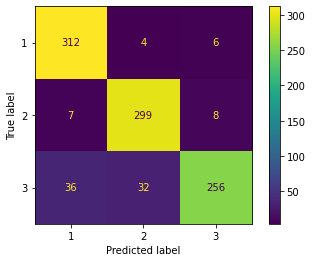



Results for highest accuracy model
Trained ShallowConvNet on single session using train/test split and got accuracy of: 0.9104166666666667


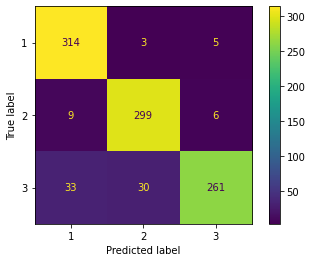

In [21]:
####################################################
# MULTI TRIAL SHALLOWCONVNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "ShallowCN_multisession_C0"
best_model_filename = f"./saved_variables/6/ShallowConvNet/{tensorboard_name}"


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_shallowcn_model.fit(
            x= mne_fixed_window_epochs_train_data,
            y= ohe_labels_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            #callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02nr")], # To be used for TF Board
            callbacks= [tensorboard_callback(tensorboard_name),
                        lowest_loss_model_save_callback(best_model_filename),
                        highest_accuracy_model_save_callback(best_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Convert labels back to original
y_test = ohe.inverse_transform(ohe_labels_test)

# Get results for best validation loss model
print("Results for lowest loss model")
keras_shallowcn_model = load_lowest_loss_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_shallowcn_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained ShallowConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model")
keras_shallowcn_model = load_highest_accuracy_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_shallowcn_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained ShallowConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del accuracy
del best_model_filename
del retrain_model
del tensorboard_name
del y_pred
del y_test

In [22]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_shallowcn_model
del mne_fixed_window_epochs_test_data
del mne_fixed_window_epochs_train_data
del ohe
del ohe_labels_test
del ohe_labels_train

<hr><hr>

## DeepConvNet

With the ShallowConvNet far outperforming the best CSP approach but being worse in inter-session performance then EEGNet, we expect the DeepConvNet to perform better in the inter-session experiments.
Again, the original implementation of the model works on 250Hz data.
The defaults provided by the EEGModels library are adopted for 128Hz, we will further adapt it to 100Hz here.
Contrary to the EEGNet implementation of EEGModels, the implementation of ShallowConvNet and DeepConvNet are not verified by the original authors, Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730)).
However, the found results are in line with the paper, thus the implementation is believed to be correct.
Once again, the functions provided in EEGModels are slightly altered to allow for parameter tuning.

### Fixed window classification: Single trial | DeepConvNet | three class MI task | 100Hz input signal

The scores are given for the best CSP approach as well as for the trained DL approaches.
Scores for the DL approach are a combination of the best model based on validation loss / validation accuracy.
TensorBoard was used to monitor the behaviour of the model over time, to ensure no overfitting tendencies occur and that enough epochs have happened to learn optimally.

**The result on subject `C` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** | **DeepConvNet: test accuracy** |
|----------------|------------------------------|---------------------------|-----------------------------------|--------------------------------|
| 0              | 0.896                        | 0.944 / 0.934             | 0.951 / 0.955                     | 0.937 / 0.944                  |
| 1              | 0.847                        | 0.931 / 0.913             | 0.937 / 0.937                     | 0.906 / 0.917                  |
| 2              | 0.719                        | 0.892 / 0.878             | 0.868 / 0.871                     | 0.861 / 0.892                  |

**The result on subject `B` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** | **DeepConvNet: test accuracy** |
|----------------|------------------------------|---------------------------|-----------------------------------|--------------------------------|
| 0              | 0.465                        | 0.569 / 0.587             | 0.496 / 0.542                     | 0.490 / 0.535                  |
| 1              | 0.560                        | 0.701 / 0.684             | 0.649 / 0.601                     | 0.618 / 0.642                  |
| 2              | 0.653                        | 0.816 / 0.792             | 0.694 / 0.712                     | 0.705 / 0.726                  |


**The result on subject `E` are:**

| **File index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** | **DeepConvNet: test accuracy** |
|----------------|------------------------------|---------------------------|-----------------------------------|--------------------------------|
| 0              | 0.701                        | 0.792 / 0.785             | 0.802 / 0.806                     | 0.729 / 0.771                  |
| 1              | 0.580                        | 0.795 / 0.799             | 0.826 / 0.823                     | 0.771 / 0.781                  |
| 2              | 0.805                        | 0.864 / 0.864             | 0.916 / 0.923                     | 0.840 / 0.857                  |

With EEGNet outperforming DeepConvNet or being very close, EEGNet is preferred over DeepConvNet.
In fact, the single session performance of ShallowConvNet is better then that of DeepConvNet.
This is mostly due to EEGNet allowing for more control to combat overfitting tendencies, which DeepConvNet suffers from.
Thus DeepConvNet is not promosing over EEGNet but ShallowConvNet is still very interesting as it allows for explainibility as further discussed in the paper by Schirrmeister et al ([2017](https://doi.org/10.1002/hbm.23730)).
ShallowConvNet is also faster in training and is likely more sample efficient.
In what follows next we study if the Deep variant of ConvNet does indeed perform better inter-session.

In [23]:
####################################################
# PREPPING THE DATA
####################################################

# Specify raw to use
mne_raw = load_mne_raw(subject= "C", index= 0)

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs, we don't need filtering since this is what we want to learn!
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Labels: should be one hot encoded!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

# Go to 2D representation
labels = labels.reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(labels).toarray()
print(f"One Hot Encoded labels: {ohe_labels[:10]}")

# Show ohe labels
np.shape(ohe_labels)
ohe_labels[:10]

# Validate OHE
print(f"Labels match before and after the One Hot Encoding: {np.array_equal(ohe.inverse_transform(ohe_labels), labels)}")

# Get effective data (half a second)
mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_data = mne_fixed_window_epochs_data * 1000000

# Delete unused variables
del mne_fixed_window_epochs
print(f"Shape of data (epochs, channels, samples): {np.shape(mne_fixed_window_epochs_data)}")

# Remove unused variables
del labels

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Using data from preloaded Raw for 960 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]
One Hot Encoded labels: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Labels match before and after the One Hot Encoding: True
Shape of data (epochs, channels, samples): (960, 21, 100)


In [24]:
####################################################
# CREATE DEEPCONVNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_deepcn_model = DeepConvNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 2s 250, paper: 1s 250)
    dropoutRate = 0.6, # dropout fraction. (default: 0.5)
    conv_filters = 4, # Conv2D kernel size (default: 5, paper: 10)
    strides = 2, # Stride size for average pooling layer (default: 2, paper: 3)
    pool_size = 2 # Pool size for average pooling layer (default: 2, paper: 3)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_deepcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_deepcn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 97, 25)        125       
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 97, 25)         13150     
                                                                 
 batch_normalization_8 (Batc  (None, 1, 97, 25)        100       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 1, 97, 25)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 48, 25)        0         
 )                                                         

Results for lowest loss model
Trained DeepConvNet on single session using train/test split and got accuracy of: 0.9375


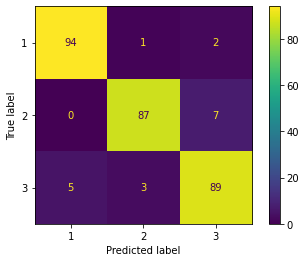



Results for highest accuracy model
Trained DeepConvNet on single session using train/test split and got accuracy of: 0.9444444444444444


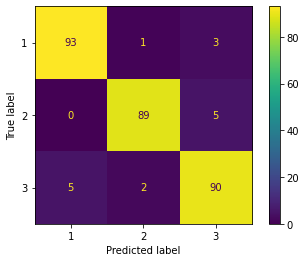

In [25]:
####################################################
# SINGLE TRIAL SHALLOWCONVNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "DeepCN_singlesession_C0_100hz_06drop"
best_model_filename = f"./saved_variables/6/DeepConvNet/{tensorboard_name}"

# Get train/test split of data from one session
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, ohe_labels, 
                                                    test_size = 0.3,
                                                    shuffle= True,
                                                    stratify= ohe_labels,                                                    
                                                    random_state=98)


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_deepcn_model.fit(
            x= X_train,
            y= y_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            #callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02nr")], # To be used for TF Board
            callbacks= [tensorboard_callback(tensorboard_name),
                        lowest_loss_model_save_callback(best_model_filename),
                        highest_accuracy_model_save_callback(best_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Convert labels back to original
y_test = ohe.inverse_transform(y_test)

# Get results for best validation loss model
print("Results for lowest loss model")
keras_deepcn_model = load_lowest_loss_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_deepcn_model.predict(X_test)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained DeepConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model")
keras_deepcn_model = load_highest_accuracy_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_deepcn_model.predict(X_test)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained DeepConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del X_train
del X_test
del y_train
del y_test
del accuracy
del y_pred
del retrain_model
del tensorboard_name
del best_model_filename

In [26]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_deepcn_model
del mne_fixed_window_epochs_data
del ohe
del ohe_labels
del mne_raw

<hr>

### Fixed window classification: Multi trial training with unseen trial testing | DeepConvNet | three class MI task | 100Hz input signal

Being outperformed by both ShallowConvNet and EEGNet, it is studied if DeepConvNet can proof to be better in inter-session performance then any of the other two studies DL approaches thus far.

**Remember the results for subject `C`**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** | **DeepConvNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|-----------------------------------|--------------------------------|
| 0              | 1 + 2           | 0.782                        | 0.916 / 0.920             | 0.903 / 0.910                     | 0.895 / 0.909                  |
| 1              | 0 + 2           | 0.635                        | 0.852 / 0.860             | 0.782 / 0.787                     | 0.822 / 0.831                  |
| 2              | 1 + 2           | 0.347                        | 0.607 / 0.594             | 0.509 / 0.489                     | 0.625 / 0.596                  |
| 0              | 1               | 0.667                        | 0.891 / 0.860             | 0.872 / 0.872                     | 0.863 / 0.903                  |
| 1              | 0               | 0.662                        | 0.794 / 0.783             | 0.713 / 0.731                     | 0.742 / 0.755                  |

**For subject `B` these results are**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** | **DeepConvNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|-----------------------------------|--------------------------------|
| 0              | 1 + 2           | 0.409                        | 0.498 / 0.489             | 0.447 / 0.448                     | 0.461 / 0.458                  |
| 1              | 0 + 2           | 0.497                        | 0.640 / 0.654             | 0.570 / 0.571                     | 0.679 / 0.671                  |
| 2              | 1 + 2           | 0.502                        | 0.677 / 0.660             | 0.602 / 0.601                     | 0.659 / 0.659                  |

**For subject `E` the results are**

| **Test index** | **Train index** | **CSP + SVM: test accuracy** | **EEGNet: test accuracy** | **ShallowConvNet: test accuracy** | **DeepConvNet: test accuracy** |
|----------------|-----------------|------------------------------|---------------------------|-----------------------------------|--------------------------------|
| 0              | 1 + 2           | 0.398                        | 0.714 / 0.713             | 0.656 / 0.681                     | 0.695 / 0.682                  |
| 1              | 0 + 2           | 0.371                        | 0.667 / 0.646             | 0.641 / 0.713                     | 0.533 / 0.571                  |
| 2              | 1 + 2           | 0.475                        | 0.734 / 0.688             | 0.699 / 0.712                     | 0.655 / 0.759                  |



In [27]:
####################################################
# PREPPING THE DATA
####################################################

# Get data and choose test trial
mne_raws = load_mne_raws(subject= "C")
test_trial = mne_raws[0]

# Init variables
epochs = []
labels_train = []

for single_mne_raw in mne_raws:
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print("Loaded train epochs and extracted labels")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nGot the test epochs")
print(f"Total amount of train labels: {len(labels_test)}")

# Go to 2D representation
labels_train = np.array(labels_train).reshape(-1, 1)
labels_test = np.array(labels_test).reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels_train = ohe.fit_transform(labels_train).toarray()
ohe_labels_test = ohe.transform(labels_test).toarray()


# Show ohe labels
print(f"OHE test and train labels, train labels:\n{ohe_labels_train[:10]}")

# Validate OHE
print(f"Train labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_train), labels_train)}")
print(f"Test labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_test), labels_test)}")

# Get training data
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train_data * 1000000
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test_data * 1000000

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw
del mne_raws
del mne_fixed_window_epochs_train
del mne_fixed_window_epochs_test
del labels_train
del labels_test

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Loaded test epochs and extracted labels
Loaded train epochs and extracted labels
Loaded train epochs and extracted labels


Concatenated the train epochs
Total amount of train labels: 1919


Got the test epochs
Total amount of train labels: 960


C:\Users\Lennert\AppData\Local\Temp\ipykernel_16324\2395505687.py:29: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
C:\Users\Lennert\AppData\Local\Temp\ipykernel_16324\2395505687.py:34: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)


OHE test and train labels, train labels:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Train labels OHE match regular labels: True
Test labels OHE match regular labels: True


In [28]:
####################################################
# CREATE DEEPCONVNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_deepcn_model = DeepConvNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 2s 250, paper: 1s 250)
    dropoutRate = 0.6, # dropout fraction. (default: 0.5)
    conv_filters = 4, # Conv2D kernel size (default: 5, paper: 10)
    strides = 2, # Stride size for average pooling layer (default: 2, paper: 3)
    pool_size = 2 # Pool size for average pooling layer (default: 2, paper: 3)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_deepcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Show summary of the model
keras_deepcn_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 97, 25)        125       
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 97, 25)         13150     
                                                                 
 batch_normalization_12 (Bat  (None, 1, 97, 25)        100       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 1, 97, 25)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 48, 25)        0         
 2D)                                                       

Results for lowest loss model
Trained DeepConvNet on single session using train/test split and got accuracy of: 0.8947916666666667


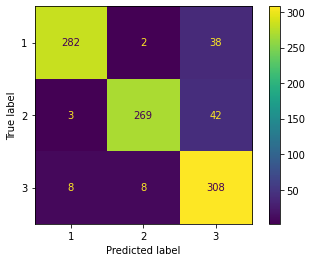



Results for highest accuracy model
Trained DeepConvNet on single session using train/test split and got accuracy of: 0.909375


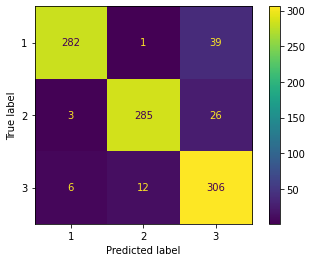

In [29]:
####################################################
# MULTI TRIAL DEEPCONVNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "DeepCN_multisession_C0"
best_model_filename = f"./saved_variables/6/DeepConvNet/{tensorboard_name}"


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_deepcn_model.fit(
            x= mne_fixed_window_epochs_train_data,
            y= ohe_labels_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            #callbacks= [tensorboard_callback("EEGNet_raw_signal_0.5s_100samps_50kernlen_02nr")], # To be used for TF Board
            callbacks= [tensorboard_callback(tensorboard_name),
                        lowest_loss_model_save_callback(best_model_filename),
                        highest_accuracy_model_save_callback(best_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Convert labels back to original
y_test = ohe.inverse_transform(ohe_labels_test)

# Get results for best validation loss model
print("Results for lowest loss model")
keras_deepcn_model = load_lowest_loss_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_deepcn_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained DeepConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model")
keras_deepcn_model = load_highest_accuracy_model(best_model_filename, custom_objects= {"square": EEGModels.square, "log": EEGModels.log})

y_pred = keras_deepcn_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Trained DeepConvNet on single session using train/test split and got accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del accuracy
del best_model_filename
del retrain_model
del tensorboard_name
del y_pred
del y_test

In [30]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del keras_deepcn_model
del mne_fixed_window_epochs_test_data
del mne_fixed_window_epochs_train_data
del ohe
del ohe_labels_test
del ohe_labels_train